In [3]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

import os
import sys
import glob as gb
import re
from pathlib import Path
from itertools import repeat

import numpy as np
import pandas as pd

from PIL import Image

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale

from mlxtend.preprocessing import minmax_scaling


import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style
import matplotlib as mpl
import matplotlib.image as mpimg
from matplotlib import cm
mpl.style.use('classic')

import pydicom as dcm
import pylab

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

from pathlib import Path
import json
torch.cuda.set_device(0)
torch.backends.cudnn.benchmark=True


import getpass
import os

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go

init_notebook_mode(True)

import keras
from keras.utils.data_utils import Sequence

# See https://stackoverflow.com/questions/14722540/smoothing-between-pixels-of-imagesc-imshow-in-matlab-like-the-matplotlib-imshow
mpl.rcParams['image.interpolation'] = 'none' # default 'bilinear'

layout=Layout(width='90%') # For ipywidgets

#import ipdb; ipdb.set_trace()

Using TensorFlow backend.


In [4]:
# Pathes
HOME = Path.home()

RAW = HOME / 'data/OriginalsAneurysm'

AUTO512 = RAW / '512Auto'
STL = RAW / 'stls.bk'

DATA = HOME / 'data/aneurysm'
PATH = DATA

CT_DCM = DATA / 'ct-512'
MASK_DCM = DATA / 'mask-512'

CT_DCM =DATA / 'ct-512' 

CT_NP = DATA / 'ct-512-NP'
MASK_NP = DATA / 'mask-512-NP'

CT_PNG = DATA / 'ct-512-PNG'
MASK_PNG = DATA / 'mask-512-PNG'

# CT_128 = DATA / 'train-128'
# MASK_128 = DATA / 'train_masks-128'

# CT_128_NP = DATA / 'ct-128-NP'
# MASK_128_NP = DATA / 'mask-128-NP'

TMP = DATA / 'tmp'

CT_NP.mkdir(exist_ok=True)
MASK_NP.mkdir(exist_ok=True)

CT_PNG.mkdir(exist_ok=True)
MASK_PNG.mkdir(exist_ok=True)

In [5]:
train_dcms = np.array(sorted(list(CT_DCM.iterdir())))
mask_dcms = np.array(sorted(list(MASK_DCM.iterdir())))

In [6]:
def dicom_shape(path):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array
    return name,np.shape(pixel_array),pixel_array

def first_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last):
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i
        
def last_nonempty_slice_index(tensor):
    last = np.shape(tensor)[0]
    for i in range(0,last)[::-1]:
        max_val = np.max(tensor[i])
        if max_val > 0:
            return i

def imshow(pixel_array):
    pixel_array[pixel_array > 0] = 255
    pixel_array = pixel_array.astype(np.uint8)
    return Image.fromarray(pixel_array)

def mask_dcm_to_png(path,target_dir,size=False):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array[:-2] # remove the last to layers
    layers = np.shape(pixel_array)[0]
    if size:
        for i in range(layers):
            clean_mask(pixel_array[i]).resize(size).save(str(target_dir/f"{name}_{i}.png"))
    else:
        for i in range(layers):
            clean_mask(pixel_array[i]).save(str(target_dir/f"{name}_{i}.png"))
    print(f"{name}",end=", ")
    
def ct_dcm_to_png(path,target_dir,size=False):
    name = path.stem
    pixel_array = dcm.read_file(str(path)).pixel_array[:-2] # remove the last to layers
    layers = np.shape(pixel_array)[0]
    if size:
        for i in range(layers):
            Image.fromarray(pixel_array[i]).resize(size).save(str(target_dir/f"{name}_{i}.png"))
    else:
        for i in range(layers):
            Image.fromarray(pixel_array[i]).save(str(target_dir/f"{name}_{i}.png"))
    print(f"{name}",end=", ")
    
def get_ct_by_index(index):
    return dcm.read_file(str(train_dcms[index])).pixel_array

def get_mask_by_index(index):
    pa = dcm.read_file(str(mask_dcms[index])).pixel_array
    pa[pa > 0] = 1024
    return pa

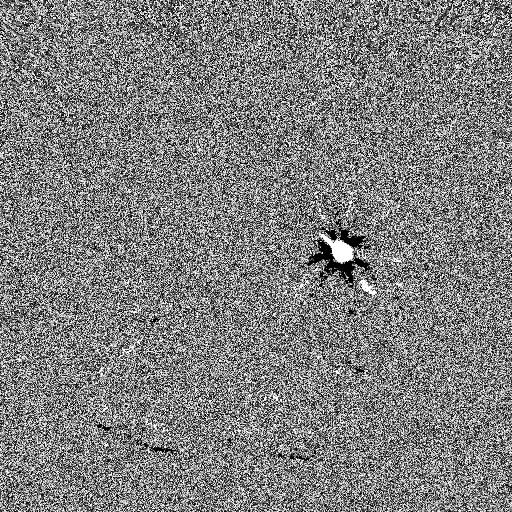

In [7]:
imshow(get_mask_by_index(1)[19])

imshow(get_ct_by_index(1)[19])

In [18]:
from unet3d import *
from unet3d.utils.patches import *
from unet3d.metrics import *
from unet3d.model import *
from unet3d.generator import *
from unet3d.training import *

In [19]:
patient = 1 # 1

ct = get_ct_by_index(patient)
mask = get_mask_by_index(patient)

image_shape = np.shape(ct)
patch_shape = (64,64,64)

overlap = 0

patch_indices = compute_patch_indices(image_shape, patch_shape, overlap, start=None)

def dshow():
    ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[0])
    mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[0])
    def show_layer(layer_num,patch_num):
        ct_patch = get_patch_from_3d_data(ct, patch_shape, patch_indices[patch_num])
        mask_patch = get_patch_from_3d_data(mask, patch_shape, patch_indices[patch_num])
        
        f = plt.figure(figsize=(20,10))
        f.add_subplot(1,2, 1)
        pylab.imshow(ct_patch[layer_num])
        f.add_subplot(1,2, 2)
        pylab.imshow(mask_patch[layer_num])
        plt.show(block=True)
    
    interact(show_layer,
             patch_num=widgets.IntSlider(min=0,max=len(patch_indices)-1,step=1,layout=layout,value=150),
             layer_num=widgets.IntSlider(min=0,max=len(ct_patch)-1,step=1,layout=layout,value=63)
            )

dshow()

interactive(children=(IntSlider(value=63, description='layer_num', layout=Layout(width='90%'), max=63), IntSli…

In [20]:
# UnetModel = isensee2017_model(input_shape=(1,32,32,32))

In [21]:
patient = 1

ct = get_ct_by_index(patient)
mask = get_mask_by_index(patient)


image_shape = np.shape(ct)
patch_shape = (64,64,64)
overlap = 0

patch_indices = compute_patch_indices(image_shape, patch_shape, overlap, start=None)

In [22]:
# X = iter(reshape_array(get_patch_from_3d_data(ct, patch_shape, patch_index)) for patch_index in patch_indices)

In [23]:
# Y = iter(reshape_array(get_patch_from_3d_data(mask, patch_shape, patch_index)) for patch_index in patch_indices)

In [24]:
# X = np.reshape(X,(64,1, 128, 128, 128))
# Y = np.reshape(Y,(64,1, 128, 128, 128))
# np.shape(X),np.shape(Y)

In [25]:
class Patient(Sequence):
    def __init__(self, patient_id):
        self.patient_id = patient_id
        self.ct = self.get_ct_by_index(self.patient_id)
        self.mask = self.get_mask_by_index(self.patient_id)
        self.image_shape = np.shape(self.ct)
        self.patch_shape = (64,64,64)
        self.batch_size = 1
        self.overlap = 0
        self.patch_indices = compute_patch_indices(self.image_shape, self.patch_shape, self.overlap, start=None)
        self.last = len(self.patch_indices) - 1
        self.masked_patches = np.array([],dtype=np.uint16)
        self.unmasked_patches = np.array([],dtype=np.uint16)
        
    def __len__(self):
        return math.ceil(len(self.patch_indices) / self.batch_size)
    
    def __getitem__(self, idx):
        return tuple(np.array([[self.X(idx)],[self.Y(idx)]]))

#     def X(self,index):
#         return get_patch_from_3d_data(self.ct, self.patch_shape, self.patch_indices[index])
        
#     def Y(self,index):
#         return get_patch_from_3d_data(self.mask, self.patch_shape, self.patch_indices[index])
        
    def X(self,idx):
        return self.reshape_array(
            get_patch_from_3d_data(self.ct, self.patch_shape, self.patch_indices[idx]))
        
    def Y(self,idx):
        return self.reshape_array(
            get_patch_from_3d_data(self.mask, self.patch_shape, self.patch_indices[idx]))
    
#     def X_gen(self):
#         for patch_index in self.patch_indices:
#             yield self.reshape_array(
#             get_patch_from_3d_data(self.ct, self.patch_shape, patch_index))
        
#     def Y_gen(self):
#         for patch_index in self.patch_indices:
#             yield self.reshape_array(
#                 get_patch_from_3d_data(self.mask, self.patch_shape, patch_index))

    def XY(self):
        for i in range(len(self.patch_indices)):
            yield np.array([self.X(i), self.Y(i)])
        
    def find_masked_patches(self):
        if self.unmasked_patches.any():
            return None
        def pfind(i):            
            if np.any(self.Y(i)):
                print("!",end="")
                self.masked_patches = np.append(self.masked_patches,i)
            else:
                print(".",end="")
                self.unmasked_patches = np.append(self.unmasked_patches,i)
            i+=1
        
        with ThreadPoolExecutor(6) as e: e.map(pfind, range(self.last))
    
    @classmethod
    def reshape_array(self,arr):
        new_shape = tuple(np.insert(np.shape(arr),0,1))
        return np.reshape(arr,new_shape)
    
    @classmethod
    def get_ct_by_index(self,index):
        return dcm.read_file(str(train_dcms[index])).pixel_array

    @classmethod
    def get_mask_by_index(self,index):
        pa = dcm.read_file(str(mask_dcms[index])).pixel_array
        pa[pa > 0] = 1
        return pa

p1 = Patient(1)
p2 = Patient(2)

train = p1
validation = p2

In [26]:
np.shape(train.__getitem__(1))

(2, 1, 1, 64, 64, 64)

In [28]:
UnetModel = isensee2017_model(input_shape=(1,64,64,64),n_labels=1)

In [29]:
#UnetModel.metrics.append(weighted_dice_coefficient_loss)
tbCallBack = keras.callbacks.TensorBoard(log_dir='./Graph',
                                         histogram_freq=0,
                                         write_graph=True,
                                         write_images=True)

In [30]:
UnetModel.fit_generator(train,
                        validation_data=validation,
                        callbacks=[tbCallBack])

Epoch 1/1
448/448 [==============================] - 236s 526ms/step - loss: -0.0104 - val_loss: -0.0040


In [34]:
UnetModel.history.params

{'epochs': 1,
 'steps': 448,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss', 'val_loss']}

In [369]:
# ct = next(X)
# mask = next(Y)
# print(ct.max(),mask.max())
# #np.shape(ct)
# #pylab.imshow(ct[0][19],cmap=pylab.cm.bone)
# pylab.imshow(mask[0][19],cmap=pylab.cm.bone)

In [373]:
# train_model(UnetModel,n_epochs=3,model_file="./kerasm",
#             training_generator=p1.XY(),
#             validation_generator=p2.XY(),
#             validation_steps=100,
#             steps_per_epoch=2)

In [389]:
# def batch_generator(X_gen,Y_gen):
#         while True:
#             yield (next(X_gen),next(Y_gen))

# train = batch_generator(p1.X_gen(),p1.Y_gen())
# validation = batch_generator(p2.X_gen(),p2.Y_gen())

In [31]:
UnetModel.get_input_at(0)

<tf.Tensor 'input_1:0' shape=(?, 1, 64, 64, 64) dtype=float32>

In [32]:
UnetModel.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1, 64, 64, 64 0                                            
__________________________________________________________________________________________________
conv3d_1 (Conv3D)               (None, 16, 64, 64, 6 448         input_1[0][0]                    
__________________________________________________________________________________________________
instance_normalization_1 (Insta (None, 16, 64, 64, 6 32          conv3d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 16, 64, 64, 6 0           instance_normalization_1[0][0]   
__________________________________________________________________________________________________
conv3d_2 (